In [ ]:
#!pip install geopandas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import os
from bs4 import BeautifulSoup  
import requests
import zipfile
import io
import nltk

#import geopandas as gpd
#import shapely
#import gensim
import tqdm
import tensorflow as tf
import keras

# Load the Drive helper and mount
from google.colab import drive
mounted_path_folder = '/content/drive'
drive.mount(mounted_path_folder, force_remount=True)
path_folder = "/content/drive/MyDrive/dsprojects/dsproject_grev/" # parent of current src folder

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

from collections import defaultdict
import scipy
import string
import re
import os

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import nltk
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
#from nltk.tokenize import word_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#path_folder_data = os.path.join(path_folder,"data","raw","filter_all_t.json")
path_folder_data = os.path.join(path_folder,"data","raw","image_review_all.json")

reviews_df_business_id_column_list = []
reviews_df_user_id_column_list = []
reviews_df_rating_column_list = []
reviews_df_review_text_column_list = []

with open(path_folder_data) as f:
    for line in tqdm.tqdm(f):
        review = (eval(line))
        temp_business_id = None
        temp_user_id = None
        temp_rating = None
        temp_review_text = None
        temp_pics = None
        temp_history_reviews = None

        if "business_id" in review:
            temp_business_id = review["business_id"]
        if "user_id" in review:
            temp_user_id = review["user_id"]
        if "rating" in review:
            temp_rating = review["rating"]
        if "review_text" in review:
            temp_review_text = review["review_text"]
        if "pics" in review:
            temp_pics = None #review["pics"] 
        
        reviews_df_business_id_column_list.append(temp_business_id)
        reviews_df_user_id_column_list.append(temp_user_id)
        reviews_df_rating_column_list.append(temp_rating)
        reviews_df_review_text_column_list.append(temp_review_text)
    f.close()
reviews_df = pd.DataFrame()
reviews_df["business_id"] = reviews_df_business_id_column_list
reviews_df["user_id"] = reviews_df_user_id_column_list
reviews_df["rating"] = reviews_df_rating_column_list
reviews_df["review_text"] = reviews_df_review_text_column_list

1487747it [01:37, 15188.06it/s]


In [ ]:
def clean_text_column(text_column):
    non_alphanumeric = string.punctuation # constant
    text_column = text_column.str.lower()
    text_column = text_column.str.translate(str.maketrans(non_alphanumeric, " "*len(non_alphanumeric)))
    return text_column

review_column_name = "review_text"
rating_column_name = "rating"
binarized_rating_column_name = "binarized_rating"
target_column_name = binarized_rating_column_name

raw_interactions_df = reviews_df

rating_column = raw_interactions_df[rating_column_name]
binarized_rating_column = rating_column > 3
target_column = binarized_rating_column
raw_interactions_df[target_column_name] = target_column

review_text_column = raw_interactions_df[review_column_name]
review_text_column = review_text_column.fillna("")
review_text_column = clean_text_column(review_text_column)

X = review_text_column
y_column_name = target_column_name
y = raw_interactions_df[y_column_name]
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y)

In [ ]:
def get_negative_words_of_stop_words_list(stop_words_list):
    negative_words = ["no","not","t","nor","against"] # constant
    contraction_not_words = [word for word in stop_words_list if word[-2:]=="'t"]
    contraction_not_words_pre_apostrophe = [word[:-2] for word in contraction_not_words]
    negative_words += contraction_not_words
    negative_words += contraction_not_words_pre_apostrophe
    return negative_words

stop_words_list = stopwords.words("english")
negative_words = get_negative_words_of_stop_words_list(stop_words_list)
#raw_recipes_df = pd.read_csv(os.path.join(PATH_FOLDER,"RAW_recipes.csv"))
for word in negative_words: stop_words_list.remove(word);
#stop_words_list += (cooking_related_words)

print("Removed stop words")
####

Removed stop words


In [ ]:
train_df = pd.DataFrame()
train_df[review_column_name] = X_train
train_df[target_column_name] = y_train

In [ ]:
# vectorizer method, stopwords, max_df
# liststr_columns
class Temp_Recipe_Vectorizer_Builder:
    def __init__(self, vectorizer, food_vocab_column):
        self.vectorizer = (vectorizer)
        food_vocab_vectorizer = vectorizer.fit(food_vocab_column)

        self.fitted_vectorizer = food_vocab_vectorizer

        food_vocab_vectorized = vectorizer.transform(food_vocab_column)

        self.vectorized_matrix = food_vocab_vectorized.tocsc()
        self.vocab2idx = self.fitted_vectorizer.named_steps["count"].vocabulary_
        self.idx2vocab = dict((v, k) for k, v in self.fitted_vectorizer.named_steps["count"].vocabulary_.items())
    def get_top_n_features_by_colwise_aggfunc(self, func, n=1000, as_words=True):
        result = np.array(func(self.vectorized_matrix, axis=0))[0].argsort()[-n:]
        if as_words:
            result = [self.idx2vocab[i] for i in result]
        return result

In [ ]:
#####

df_temp = train_df#[[review_column_name,target_column_name]]
group_column_name = target_column_name

df_temp = df_temp.sort_values([group_column_name])
threshold_index = list(df_temp[group_column_name].values).index(True)
assert threshold_index != 0

tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words_list)

tfidf_reviews = tfidf_vectorizer.fit_transform(df_temp[review_column_name]).tocsc()
vocab_word2idx = tfidf_vectorizer.vocabulary_
vocab_idx2word = dict(zip(list(vocab_word2idx.values()), list(vocab_word2idx.keys())))

print("vocab size:", len(vocab_word2idx))

tfidf_reviews_negative = tfidf_reviews[:threshold_index,:]
tfidf_reviews_positive = tfidf_reviews[threshold_index:,:]

tfidf_reviews_negative_collapsed = np.squeeze(np.asarray(scipy.sparse.csc_matrix.mean(tfidf_reviews_negative,axis=0)))
tfidf_reviews_positive_collapsed = np.squeeze(np.asarray(scipy.sparse.csc_matrix.mean(tfidf_reviews_positive,axis=0)))

tfidf_sentiments = np.array([tfidf_reviews_negative_collapsed, tfidf_reviews_positive_collapsed])

print("Creation of 2xV Matrix")

vocab size: 291456
Creation of 2xV Matrix


In [ ]:
############

column_amount = tfidf_sentiments.shape[1]
column_wise_argmaxer = tfidf_sentiments.argmax(axis=0) # gets the row index of the greater row for each column
negative_columns_indexer = np.arange(column_amount)[np.where(column_wise_argmaxer==0)[0]]
tfidf_sentiments_negative_columns = tfidf_sentiments[:,negative_columns_indexer]
assert tfidf_sentiments_negative_columns.shape[1] == np.sum(column_wise_argmaxer==0)
negative_skewed_words = [vocab_idx2word[i] for i in negative_columns_indexer]

#########

N = 100
negative_skewed_words_by_contrast = pd.Series(index=negative_skewed_words, 
                                              data=list(np.abs(np.diff(tfidf_sentiments_negative_columns,axis=0))[0]))
top_n_tfidf_negative_skewed_words_by_contrast = negative_skewed_words_by_contrast.sort_values(ascending=False)[:N]

############

top_n_tfidf_negative_skewed_words_by_contrast_list = list(top_n_tfidf_negative_skewed_words_by_contrast.index)
learned_mapping = dict(zip(top_n_tfidf_negative_skewed_words_by_contrast_list,list(range(N))))
learned_count_vectorizer = CountVectorizer(vocabulary=learned_mapping)

##########

X_train = learned_count_vectorizer.transform(X_train).tocsc().A

y_train = 1-(y_train.astype(int).values)

In [ ]:
###########

def fit_model_subset(X_train_, y_train_):
    model = LogisticRegression(class_weight="balanced",max_iter=300)
    model.fit(X_train_, y_train_)
    predictions = model.predict(X_train_)
    acc = np.mean(predictions==y_train_)
    print(acc)
    #confusion_matrix_array = confusion_matrix(y_train_, predictions, normalize="true")
    #confusion_matrix_array
    return model

def undersampling_fitting(
    X_train_, 
    y_train_,
    num_subset_model_fittings = 10
    ):
    good_reviews_indices = np.where(y_train_ == 0)[0]
    bad_reviews_indices = np.where(y_train_ == 1)[0]
    print(len(bad_reviews_indices)/(len(bad_reviews_indices) + len(good_reviews_indices)))
    subset_size = bad_reviews_indices.shape[0] # len(good_reviews_indices) // num_subset_model_fittings
    subset_models = []

    for i in (range(num_subset_model_fittings)):
        good_reviews_subset_indices = np.random.choice(good_reviews_indices,size=subset_size)

        good_reviews_subset = X_train_[good_reviews_subset_indices,:]
        bad_reviews = X_train_[bad_reviews_indices,:]

        X_train_subset = np.vstack([good_reviews_subset, bad_reviews])
        y_train_subset = np.array(
            [0 for _ in range(good_reviews_subset.shape[0])] + \
            [1 for _ in range(bad_reviews.shape[0])]
        )

        shuffler_indices = np.arange((good_reviews_subset.shape[0]) + (bad_reviews.shape[0]))
        np.random.shuffle(shuffler_indices)

        X_train_subset_shuffled = X_train_subset[shuffler_indices]
        y_train_subset_shuffled = y_train_subset[shuffler_indices]

        #print(X_train_subset_shuffled.shape)

        subset_model = fit_model_subset(X_train_subset_shuffled, y_train_subset_shuffled)
        subset_models.append(subset_model)

    return subset_models

##############

subset_models = undersampling_fitting(X_train, y_train, 10)

model_coefs = np.array([model.coef_ for model in subset_models])
model_intercepts = np.array([model.intercept_ for model in subset_models])
model_coefs = np.squeeze(model_coefs,1)
model_intercepts = np.squeeze(model_intercepts,1)
model_coefs_std = np.std(model_coefs, axis=1, keepdims=1,ddof=0)
model_coefs_ = model_coefs / model_coefs_std
model_coefs_avg = np.mean(model_coefs_,axis=0)
model_intercepts_ = model_intercepts #/ np.squeeze(model_coefs_std,1)
model_intercepts_avg = np.mean(model_intercepts_)

########################

X_test = learned_count_vectorizer.transform(X_test).tocsc().A
y_test = 1-(y_test.astype(int).values)

sigmoid = lambda x: 1/(1+(np.exp(-x)))

predictions_prob_undersampled = sigmoid((X_test @ np.expand_dims(model_coefs_avg,1)+model_intercepts_avg))

predictions = (predictions_prob_undersampled > 0.5).astype(int)

predictions = np.squeeze(predictions,1)

y_test.shape, predictions.shape

acc = np.mean(predictions==y_test)
print(acc)

0.12447459692958479
0.7865973072215422
0.7867845057239542
0.7862157102743178
0.7850997192022464
0.7859493124055008
0.7865901072791418
0.7862121103031176
0.7872057023543811
0.7863849089207287
0.7866693066455468
0.8394943229632975


[[0.85696782 0.14303218]
 [0.28340929 0.71659071]]


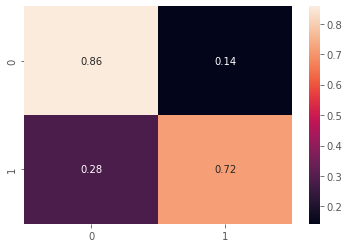

In [ ]:
confusion_matrix_array = confusion_matrix(y_test, predictions, normalize="true")
print(confusion_matrix_array)
heatmap = sns.heatmap(confusion_matrix_array, annot=True)

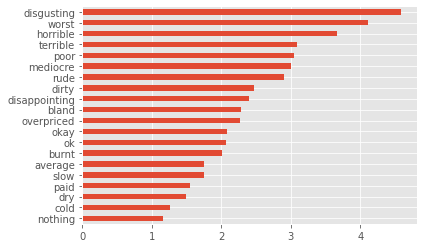

In [ ]:
pd.Series(index=top_n_tfidf_negative_skewed_words_by_contrast.index, 
          data=model_coefs_avg).sort_values(ascending=False).head(20)[::-1].plot.barh()#(type="barh")